In [3]:
library(forecast)
library(car)
library(ggplot2)
#library(zoo)
library(scales)
library(repr)

options(scipen=999)

# Change plot size to 10 x 6
options(repr.plot.width=8, repr.plot.height=5)

jp_data <- read.csv2("japan_employment.csv")
#Remove last row, 2015-01
jp_data <- jp_data[1:nrow(jp_data) - 1,]
jp_data$Date <- as.Date(jp_data$Date, format = "%Y-%m-%d")
#Create column with month value
jp_data$Month <- sapply(jp_data$Date, function(x) {format(as.Date(x), "%m")})
#jp_observed_ts <- zoo(jp_data)

head(jp_data)

Warning message:
: package 'forecast' was built under R version 3.2.5Loading required package: zoo
Warning message:
: package 'zoo' was built under R version 3.2.5
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: timeDate
Warning message:
: package 'timeDate' was built under R version 3.2.3This is forecast 7.1 

Warning message:
: package 'car' was built under R version 3.2.5Warning message:
: package 'ggplot2' was built under R version 3.2.5Warning message:
: package 'scales' was built under R version 3.2.5

,Date,Value,Month
1,2002-01-01,67.70215,01
2,2002-02-01,67.55654,02
3,2002-03-01,67.91463,03
4,2002-04-01,68.32146,04
5,2002-05-01,68.32711,05
6,2002-06-01,68.58675,06


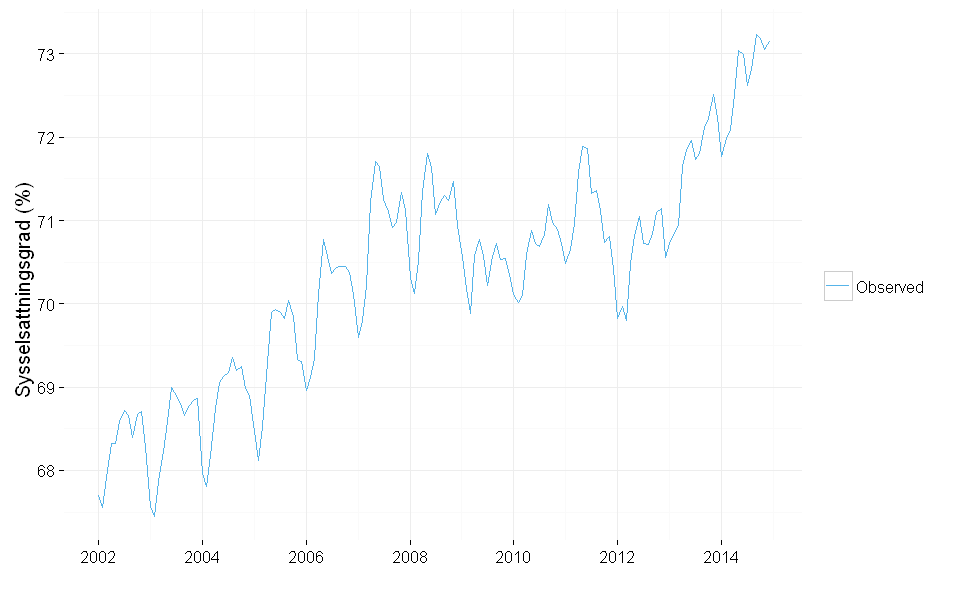

In [18]:
ggplot(jp_data, aes()) +
  geom_line(aes(x = Date, y = Value, color="Observed")) +
  scale_colour_manual(name="", values=c(Observed="#56B4E9")) +
  theme_bw() +
  theme(plot.background = element_blank(), 
    panel.border = element_blank(),
    axis.line = element_line(color = 'black'),
    panel.grid.major.x = element_line(colour = "grey93"),
    panel.grid.major.y = element_line(colour = "grey93"),
    axis.title.y = element_text(hjust = 0.45, vjust = 1.05)) +
  ylab("Sysselsattningsgrad (%)") +
  xlab("")

Ej stationär, diffa trend (1)

Warning message:
: Removed 1 rows containing missing values (geom_path).

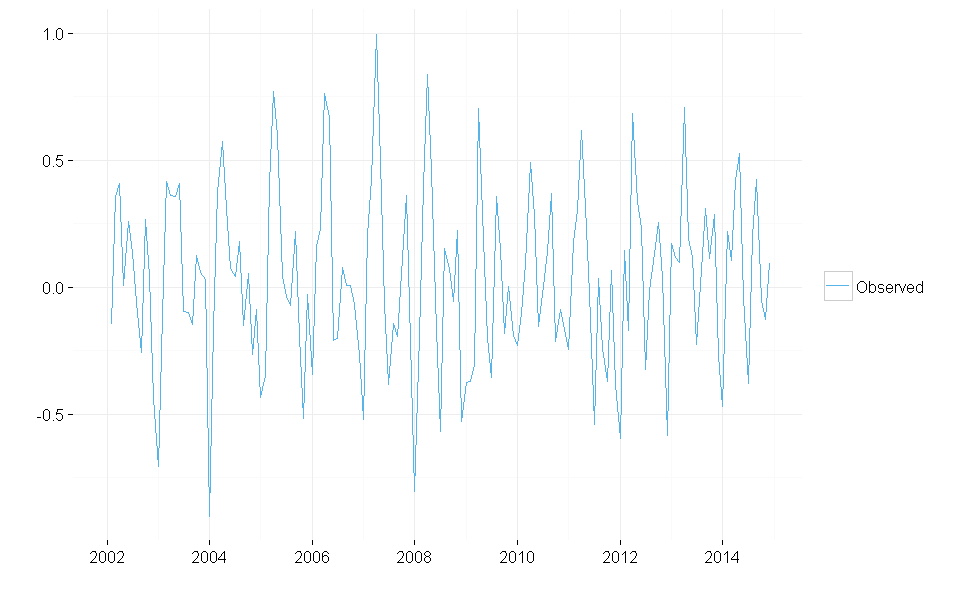

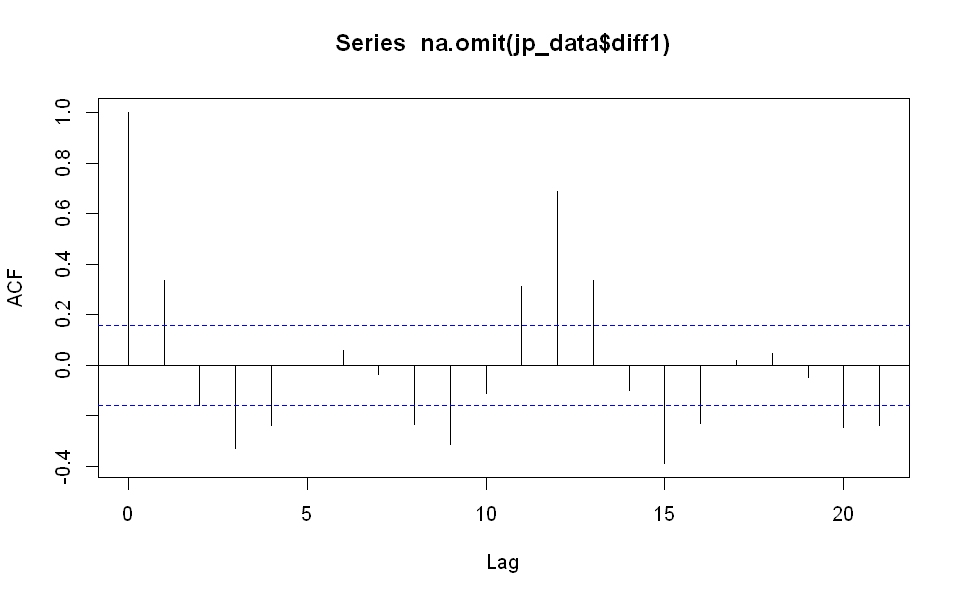

In [10]:
#help(diff)
diff1 <- diff(jp_data$Value, lag = 1)
jp_data$diff1 <- c(NA, diff1)

ggplot(jp_data, aes()) +
  geom_line(aes(x = Date, y = diff1, color="Observed")) +
  scale_colour_manual(name="", values=c(Observed="#56B4E9")) +
  theme_bw() +
  theme(plot.background = element_blank(), 
    panel.border = element_blank(),
    axis.line = element_line(color = 'black'),
    panel.grid.major.x = element_line(colour = "grey93"),
    panel.grid.major.y = element_line(colour = "grey93"),
    axis.title.y = element_text(hjust = 0.45, vjust = 1.05)) +
  ylab("") +
  xlab("")

acf(na.omit(jp_data$diff1))

Ej stationär, diffa säsong (12)

Warning message:
: Removed 13 rows containing missing values (geom_path).

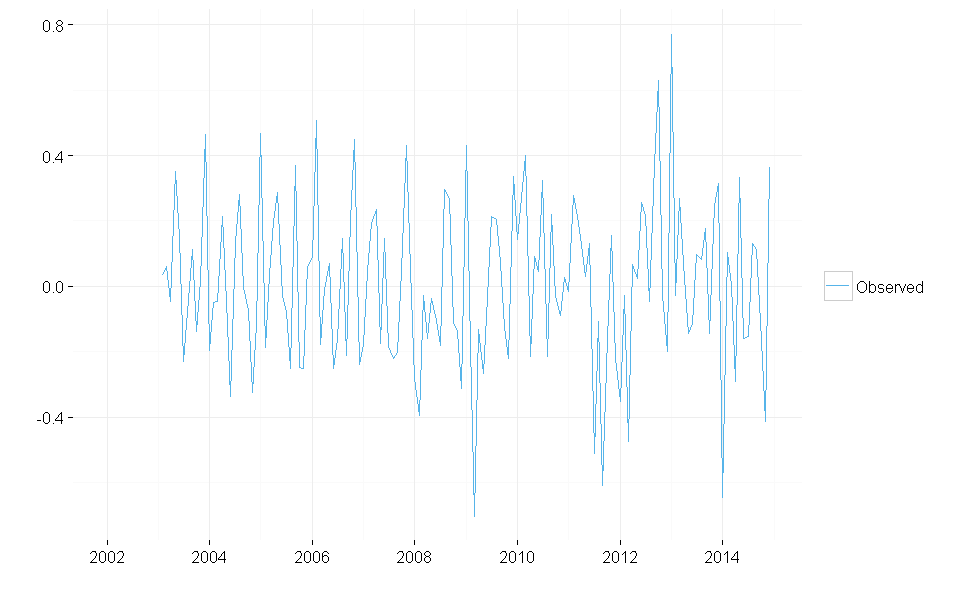

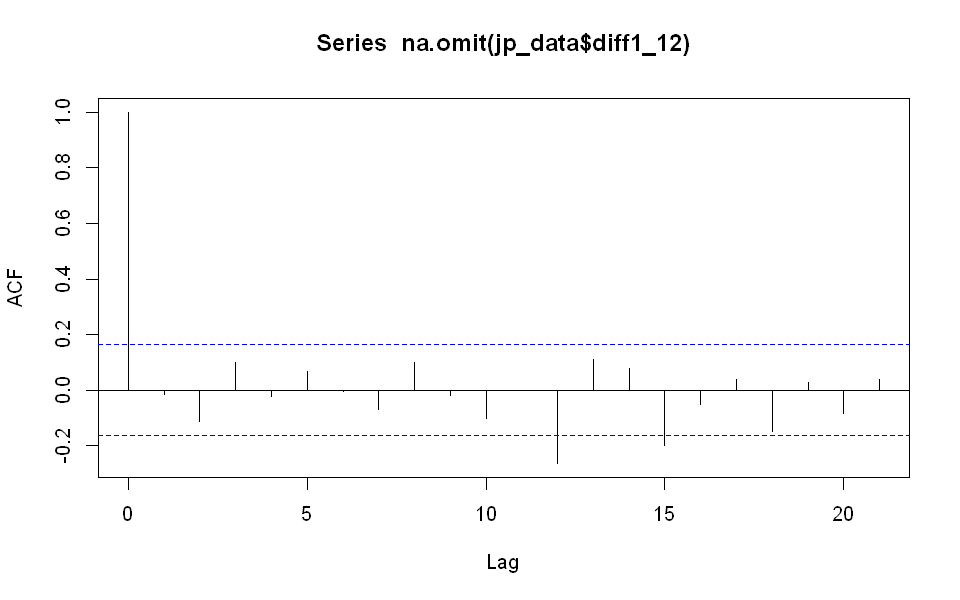

In [11]:
#help(diff)
diff1_12 <- diff(jp_data$diff1, lag = 12)
jp_data$diff1_12 <- c(rep(NA, 12), diff1_12)

ggplot(jp_data, aes()) +
  geom_line(aes(x = Date, y = diff1_12, color="Observed")) +
  scale_colour_manual(name="", values=c(Observed="#56B4E9")) +
  theme_bw() +
  theme(plot.background = element_blank(), 
    panel.border = element_blank(),
    axis.line = element_line(color = 'black'),
    panel.grid.major.x = element_line(colour = "grey93"),
    panel.grid.major.y = element_line(colour = "grey93"),
    axis.title.y = element_text(hjust = 0.45, vjust = 1.05)) +
  ylab("") +
  xlab("")

acf(na.omit(jp_data$diff1_12))

Stationär ishhh?


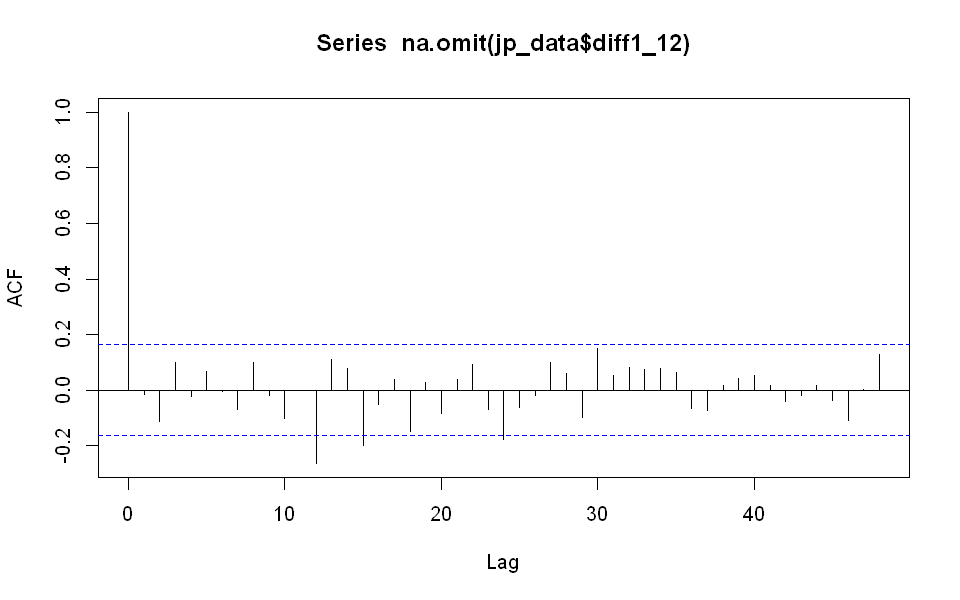

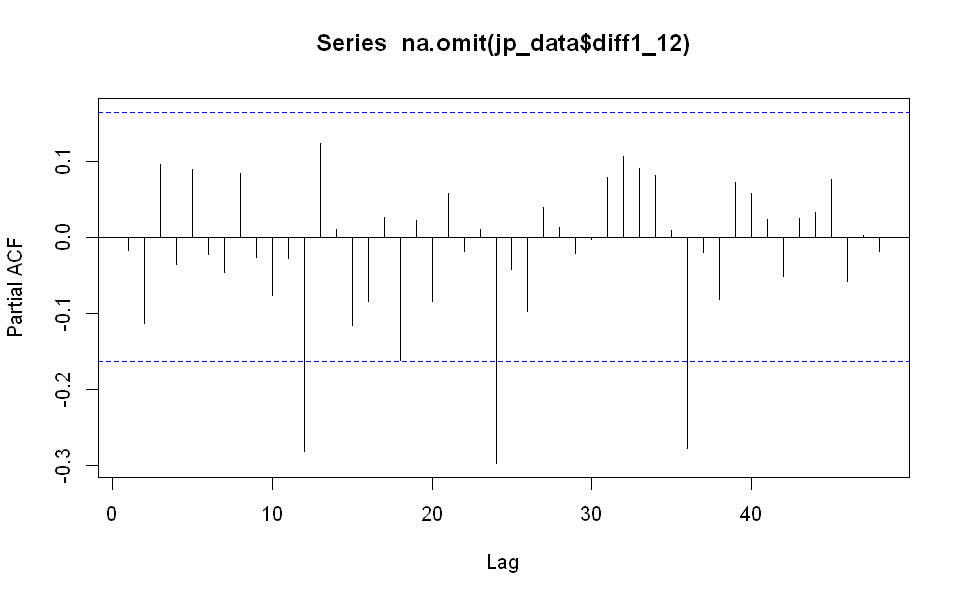

In [12]:
#help(acf)
acf(na.omit(jp_data$diff1_12), lag.max = 48)
pacf(na.omit(jp_data$diff1_12), lag.max = 48)

SARIMA(0,1,0)(3,1,0)

Series: jp_data$Value 
ARIMA(0,1,0)(3,1,0)[12]                    

Coefficients:
         sar1     sar2     sar3
      -0.4870  -0.4241  -0.3407
s.e.   0.0846   0.0856   0.0901

sigma^2 estimated as 0.04741:  log likelihood=13.4
AIC=-18.81   AICc=-18.52   BIC=-6.96

Training set error measures:
                      ME      RMSE       MAE        MPE      MAPE      MASE
Training set 0.009799537 0.2062779 0.1576524 0.01370641 0.2236822 0.5825672
                    ACF1
Training set 0.005323405
[1] "P-values"


sar1              sar2              sar3 
0.000000008574125 0.000000717500531 0.000156754157551


	Box-Ljung test

data:  na.omit(residuals(sarima_model))
X-squared = 10.935, df = 8, p-value = 0.2054



	Box-Ljung test

data:  na.omit(residuals(sarima_model))
X-squared = 28.301, df = 20, p-value = 0.1025



	Box-Ljung test

data:  na.omit(residuals(sarima_model))
X-squared = 39.967, df = 32, p-value = 0.1574


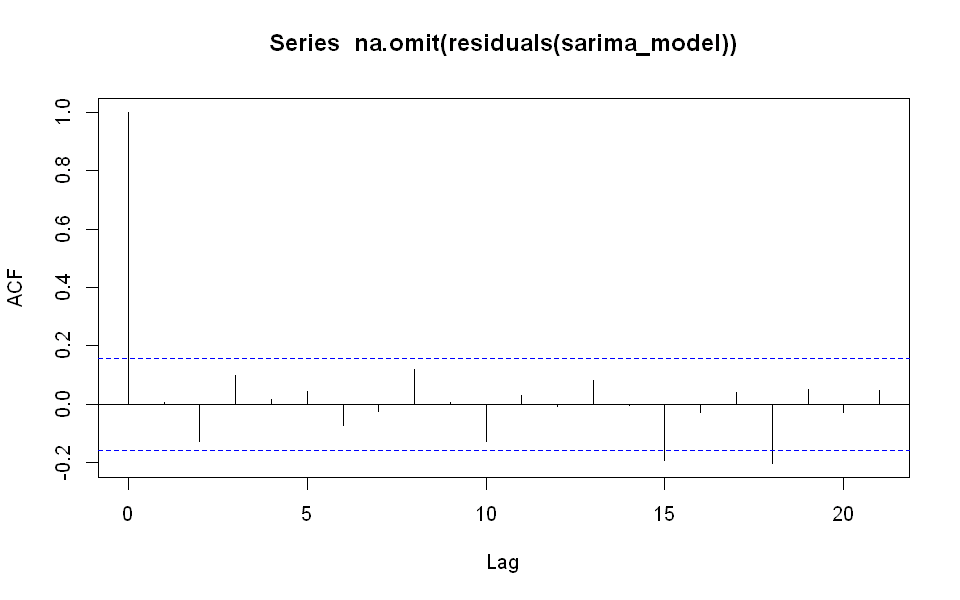

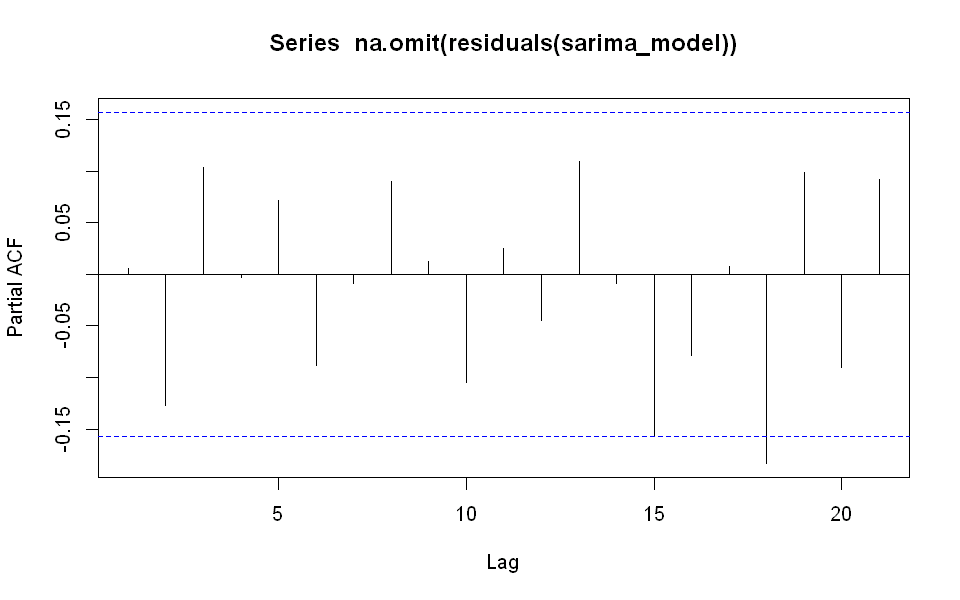

In [13]:
#help(Arima)
sarima_model <- Arima(jp_data$Value, c(0,1,0), seasonal=list(order=c(3,1,0),period=12))

summary(sarima_model)

print("P-values")
(1-pnorm(abs(sarima_model$coef)/sqrt(diag(sarima_model$var.coef))))*2


Box.test(na.omit(residuals(sarima_model)), lag=12, fitdf=4, type="Ljung")
Box.test(na.omit(residuals(sarima_model)), lag=24, fitdf=4, type="Ljung")
Box.test(na.omit(residuals(sarima_model)), lag=36, fitdf=4, type="Ljung")

acf(na.omit(residuals(sarima_model)))
pacf(na.omit(residuals(sarima_model)))

    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
157       72.78752 72.50847 73.06657 72.36075 73.21430
158       72.97906 72.58442 73.37370 72.37551 73.58262
159       73.12879 72.64545 73.61212 72.38959 73.86798
160       73.65444 73.09633 74.21255 72.80089 74.50799
161       74.07157 73.44759 74.69555 73.11727 75.02587
162       74.06840 73.38486 74.75193 73.02301 75.11378
163       73.64781 72.90951 74.38612 72.51867 74.77695
164       73.76355 72.97426 74.55283 72.55644 74.97065
165       73.92933 73.09217 74.76649 72.64900 75.20965
166       73.80246 72.92002 74.68491 72.45288 75.15205
167       73.78095 72.85543 74.70646 72.36550 75.19640
168       73.63251 72.66584 74.59917 72.15411 75.11090

Warning message:
: Removed 12 rows containing missing values (geom_path).Warning message:
: Removed 12 rows containing missing values (geom_path).Warning message:
: Removed 156 rows containing missing values (geom_path).

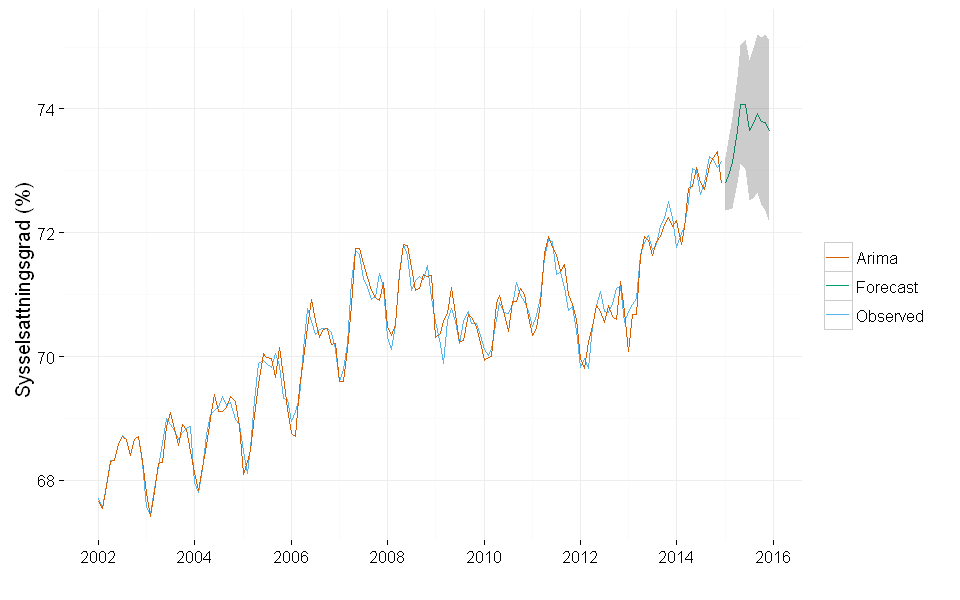

In [19]:
sarima_forecast <- forecast(sarima_model, 12)
sarima_forecast

forecast_mean <- sarima_forecast$mean
forecast_high <- sarima_forecast$upper[,2]
forecast_low <- sarima_forecast$lower[,2]

predict_data <- data.frame(Date = c(jp_data$Date, seq(as.Date("2015-01-01"), by = "month", length.out = 12)),
                           Value = c(jp_data$Value, rep(NA, 12)),
                           Arima = c(as.numeric(sarima_forecast$fitted), rep(NA, 12)),
                           Forecast = c(rep(NA, 156), forecast_mean),
                           forecast_high = c(rep(NA, 156), forecast_high),
                           forecast_low = c(rep(NA, 156), forecast_low))
#predict_data

ggplot(predict_data, aes()) +
  geom_line(aes(x = Date, y = Value, color="Observed")) +
  geom_line(aes(x = Date, y = Arima, color="Arima")) +
  geom_line(aes(x = Date, y = Forecast, color="Forecast")) +
  geom_ribbon(aes(x = Date, ymin=forecast_low, ymax=forecast_high), alpha=.25) +
  scale_colour_manual(name="", values=c(Observed="#56B4E9", Forecast="#009E73", Arima="#D55E00" )) +
  theme_bw() +
  theme(plot.background = element_blank(), 
    panel.border = element_blank(),
    axis.line = element_line(color = 'black'),
    panel.grid.major.x = element_line(colour = "grey93"),
    panel.grid.major.y = element_line(colour = "grey93"),
    axis.title.y = element_text(hjust = 0.45, vjust = 1.05)) +
  ylab("Sysselsattningsgrad (%)") +
  xlab("")